# <b>Quora Question Pairs</b>

# Introduction

Quora is a platform for Q&A, just like StackOverflow. But quora is more of a general-purpose Q&A platform that means there is not much code like in StackOverflow.

One of the many problems that quora face is the duplication of questions. Duplication of question ruins the experience for both the questioner and the answerer. Since the questioner is asking a duplicate question, we can just show him/her the answers to the previous question. And the answerer doesn't have to repeat his/her answer for essentially the same questions.

# Business Objectives and Constraints

* There is no strict latency requirement.
* We would like to have interpretability but it is not absolutely mandatory.
* The cost of misclassification is medium.
* Both classes (duplicate or not) are equally important.

# Data Overview

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import re
from fuzzywuzzy import fuzz
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb
import nltk
import time
from matplotlib.pyplot import figure
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import MinMaxScaler
from joblib import dump, load
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
# import optuna
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import warnings
import gc
from sklearn.model_selection import cross_val_score
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


False

In [22]:
data = pd.read_csv('train.csv.zip')

In [23]:
print(data.columns)
print(data.is_duplicate.unique())
print(data.is_duplicate.value_counts())
print(data.shape)

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')
[0 1]
0    255027
1    149263
Name: is_duplicate, dtype: int64
(404290, 6)


Available Columns : <b>id, qid1, qid2, question1, question2, is_duplicate</b><br>
Class labels : <b>0, 1</b><br>
Total training data / No. of rows :  <b>404290</b><br>
No. of columns :  <b>6</b><br>
**is_duplicate** is the dependent variable.<br>
No. of non-duplicate data points is <b>255027</b><br>
No. of duplicate data points is <b>149263</b>

We have **404290** training data points. And only **36.92%** are positive. That means it is an imbalanced dataset.

# Business Metrics

It is a binary classification.
* We need to minimize the log loss for this challenge.

# Basic EDA

In [7]:
testdata = pd.read_csv('test.csv')
print(testdata.shape)

(2345796, 3)


In [6]:
data.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
testdata.head(5)

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


Test data don't have question ids. So the independent variables are **question1**, **question2** and the dependent variable is **is_duplicate**.

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [24]:
data = data.dropna()
print(data.shape)

(404287, 6)


In [25]:
print(data.duplicated(('question1', 'question2')).sum())

0


3 rows had null values. So We removed them and now We have **404287** question pairs.

0    0.630799
1    0.369201
Name: is_duplicate, dtype: float64


<AxesSubplot:title={'center':'Distribution of classes'}>

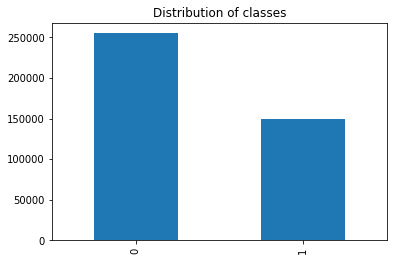

In [26]:
duplicate_value_counts = data.is_duplicate.value_counts()
print(duplicate_value_counts/duplicate_value_counts.sum())
plt.title('Distribution of classes')
duplicate_value_counts.plot.bar()

**36.92%** of question pairs are duplicates and **63.08%** of questions pair non-duplicate.

In [27]:
qids = np.append(data.qid1.values,data.qid2.values)
print(len(set(qids)))
print(len(qids))

537929
808574


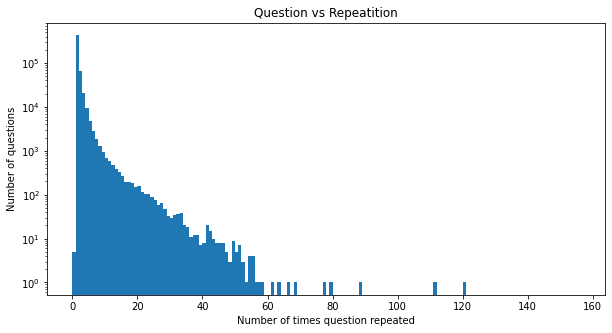

0 157


In [15]:
occurences = np.bincount(qids)
plt.figure(figsize=(10,5)) 
plt.hist(occurences, bins=range(0,np.max(occurences)))
plt.yscale('log')
plt.xlabel('Number of times question repeated')
plt.ylabel('Number of questions')
plt.title('Question vs Repeatition')
plt.show()
print(np.min(occurences), np.max(occurences))

* Out of **808574** total questions (including both question1 and question2), **537929** are unique.
* Most of the questions are repeated very few times. Only a few of them are repeated multiple times.
* One question is repeated **157** times which is the max number of repetitions.

In [16]:
print(data.question1.apply(len).min())
print(data.loc[data.question1.apply(len).argmin()])
print(data.question2.apply(len).min())
print(data.loc[data.question2.apply(len).argmin()])

1
id                                                           3306
qid1                                                         6553
qid2                                                         6554
question1                                                       .
question2       Why is Cornell's endowment the lowest in the I...
is_duplicate                                                    0
Name: 3306, dtype: object
1
id                                                          47056
qid1                                                        84067
qid2                                                        84068
question1       Is there anywhere in the world offering pain m...
question2                                                       ?
is_duplicate                                                    0
Name: 47056, dtype: object


There are some questions with very few characters, which does not make sense. It will be taken care of later with Data Cleaning.

# Data Cleaning

In [8]:
def preprocess_text(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    x = re.sub(r"http\S+", "", x)
    x = re.sub('\W', ' ', x)
    
    lemmatizer = WordNetLemmatizer()
    x = lemmatizer.lemmatize(x)
    bfs = BeautifulSoup(x)
    x = bfs.get_text()
    x = x.strip()
    return x

In [9]:
def data_cleaning(data):
    newdata = pd.DataFrame()
    newdata['question1_final'] = data.question1.apply(preprocess_text)
    newdata['question2_final'] = data.question2.apply(preprocess_text)
    return newdata

In [19]:
traindata = data_cleaning(data)

In [18]:
testdata = data_cleaning(testdata)

In [28]:
print(data.head())

   id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0  


In [21]:
print(traindata.head())

                                     question1_final  \
0  what is the step by step guide to invest in sh...   
1  what is the story of kohinoor  koh i noor  dia...   
2  how can i increase the speed of my internet co...   
3  why am i mentally very lonely  how can i solve it   
4  which one dissolve in water quikly sugar  salt...   

                                     question2_final  
0  what is the step by step guide to invest in sh...  
1  what would happen if the indian government sto...  
2  how can internet speed be increased by hacking...  
3  find the remainder when  math 23  24   math  i...  
4             which fish would survive in salt water  


* We have converted everything to lower case.
* We have removed contractions.
* We have replaced currency symbols with currency names.
* We have also removed hyperlinks.
* We have removed non-alphanumeric characters.
* We have removed inflections with word lemmatizer.
* We have also removed HTML tags.

# Feature Extraction

In [10]:
def doesMatch (q, match):
    q1, q2 = q['question1_final'], q['question2_final']
    q1 = q1.split()
    q2 = q2.split()
    if len(q1)>0 and len(q2)>0 and q1[match]==q2[match]:
        return 1
    else:
        return 0

In [12]:
def feature_extract(data):
    data['q1_char_num'] = data.question1_final.apply(len)
    data['q2_char_num'] = data.question2_final.apply(len)
    data['q1_word_num'] = data.question1_final.apply(lambda x: len(x.split()))
    data['q2_word_num'] = data.question2_final.apply(lambda x: len(x.split()))
    
    data['total_word_num'] = data['q1_word_num'] + data['q2_word_num']
    data['differ_word_num'] = abs(data['q1_word_num'] - data['q2_word_num'])
    data['same_first_word'] = data.apply(lambda x: doesMatch(x, 0) ,axis=1)
    data['same_last_word'] = data.apply(lambda x: doesMatch(x, -1) ,axis=1)
    data['total_unique_word_num'] = data.apply(lambda x: len(set(x.question1_final.split()).union(set(x.question2_final.split()))) ,axis=1)
    data['total_unique_word_withoutstopword_num'] = data.apply(lambda x: len(set(x.question1_final.split()).union(set(x.question2_final.split())) - set(stopwords.words('english'))) ,axis=1)
    data['total_unique_word_num_ratio'] = data['total_unique_word_num'] / data['total_word_num']
    
    data['common_word_num'] = data.apply(lambda x: len(set(x.question1_final.split()).intersection(set(x.question2_final.split()))) ,axis=1)
    data['common_word_ratio'] = data['common_word_num'] / data['total_unique_word_num']
    data['common_word_ratio_min'] = data['common_word_num'] / data.apply(lambda x: min(len(set(x.question1_final.split())), len(set(x.question2_final.split()))) ,axis=1) 
    data['common_word_ratio_max'] = data['common_word_num'] / data.apply(lambda x: max(len(set(x.question1_final.split())), len(set(x.question2_final.split()))) ,axis=1) 
    
    data['common_word_withoutstopword_num'] = data.apply(lambda x: len(set(x.question1_final.split()).intersection(set(x.question2_final.split())) - set(stopwords.words('english'))) ,axis=1)
    data['common_word_withoutstopword_ratio'] = data['common_word_withoutstopword_num'] / data['total_unique_word_withoutstopword_num']
    data['common_word_withoutstopword_ratio_min'] = data['common_word_withoutstopword_num'] / data.apply(lambda x: min(len(set(x.question1_final.split()) - set(stopwords.words('english'))), len(set(x.question2_final.split()) - set(stopwords.words('english')))) ,axis=1) 
    data['common_word_withoutstopword_ratio_max'] = data['common_word_withoutstopword_num'] / data.apply(lambda x: max(len(set(x.question1_final.split()) - set(stopwords.words('english'))), len(set(x.question2_final.split()) - set(stopwords.words('english')))) ,axis=1) 
    
    data["fuzz_ratio"] = data.apply(lambda x: fuzz.ratio(x.question1_final, x.question2_final), axis=1)
    data["fuzz_partial_ratio"] = data.apply(lambda x: fuzz.partial_ratio(x.question1_final, x.question2_final), axis=1)
    data["fuzz_token_set_ratio"] = data.apply(lambda x: fuzz.token_set_ratio(x.question1_final, x.question2_final), axis=1)
    data["fuzz_token_sort_ratio"] = data.apply(lambda x: fuzz.token_sort_ratio(x.question1_final, x.question2_final), axis=1)
    data.fillna(0, inplace=True)
    return data

FuzzyWuzzy uses Levenshtein Distance to calculate the differences between sequences. https://github.com/seatgeek/fuzzywuzzy

In [27]:
traindata = feature_extract(traindata)

In [19]:
testdata = feature_extract(testdata)

In [15]:
traindata.head()

,question1_final,question2_final,q1_char_num,q2_char_num,q1_word_num,q2_word_num,total_word_num,differ_word_num,same_first_word,same_last_word,...,common_word_ratio_min,common_word_ratio_max,common_word_withoutstopword_num,common_word_withoutstopword_ratio,common_word_withoutstopword_ratio_min,common_word_withoutstopword_ratio_max,fuzz_ratio,fuzz_partial_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,65,56,14,12,26,2,1,0,...,1.000000,0.916667,5,0.833333,1.0,0.833333,93,100,100,93
1,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,50,87,10,15,25,5,1,0,...,0.700000,0.500000,4,0.363636,0.8,0.400000,66,74,86,63
2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,72,58,14,10,24,4,1,0,...,0.400000,0.285714,2,0.222222,0.4,0.333333,54,53,66,66
3,why am i mentally very lonely how can i solve it,find the remainder when math 23 24 math i...,49,64,11,13,24,2,0,0,...,0.000000,0.000000,0,0.000000,0.0,0.000000,35,39,36,36
4,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,75,38,13,7,20,6,1,0,...,0.571429,0.307692,2,0.153846,0.4,0.200000,46,55,67,47


In [77]:
traindata.shape

(404287, 25)

We have created **23** features from the questions.
* We have created features q1_word_num, q2_word_num with count of characters for both questions.
* We have created total_word_num feature which is equal to sum of q1_word_num and q2_word_num.
* We have created differ_word_num feature which is absolute difference between q1_word_num and q2_word_num.
* We have created same_first_word feature which is 1 if both questions have same first word otherwise 0.
* We have created same_last_word feature which is 1 if both questions have same last word otherwise 0.
* We have created total_unique_word_num feature which is equal to total number of unique words in both questions.
* We have created total_unique_word_withoutstopword_num feature which is equal to total number of unique words in both questions without the stop words.
* The total_unique_word_num_ratio is equal to total_unique_word_num divided by total_word_num.
* We have created common_word_num feature which is count of total common words in both questions.
* The common_word_ratio feature is equal to common_word_num divided by total_unique_word_num.
* The common_word_ratio_min is equal to common_word_num divided by minimum number of words between question 1 and question 2.
* The common_word_ratio_max is equal to common_word_num divided by maximum number of words between question 1 and question 2.
* We have created common_word_withoutstopword_num feature which is count of total common words in both questions excluding the stopwords.
* The common_word_withoutstopword_ratio feature is equal to common_word_withoutstopword_num divided by total_unique_word_withoutstopword_num.
* The common_word_withoutstopword_ratio_min is equal to common_word_withoutstopword_num divided by minimum number of words between question 1 and question 2 excluding the stopwords.
* The common_word_withoutstopword_ratio_max is equal to common_word_withoutstopword_num divided by maximum number of words between question 1 and question 2 excluding the stopwords.
* Then we have extracted fuzz_ratio, fuzz_partial_ratio, fuzz_token_set_ratio and fuzz_token_sort_ratio features with fuzzywuzzy string matching tool. Reference: https://github.com/seatgeek/fuzzywuzzy

# EDA with Features

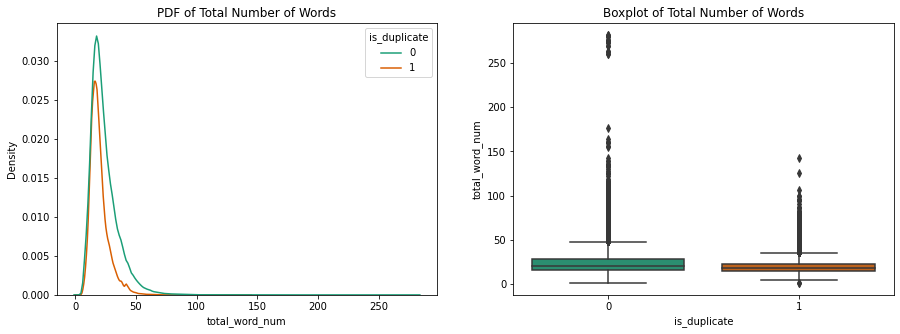

In [5]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Total Number of Words')
sns.kdeplot(traindata['total_word_num'], hue=data.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Total Number of Words')
sns.boxplot(x=data.is_duplicate, y=traindata['total_word_num'], palette="Dark2", ax=ax[1])
plt.show()

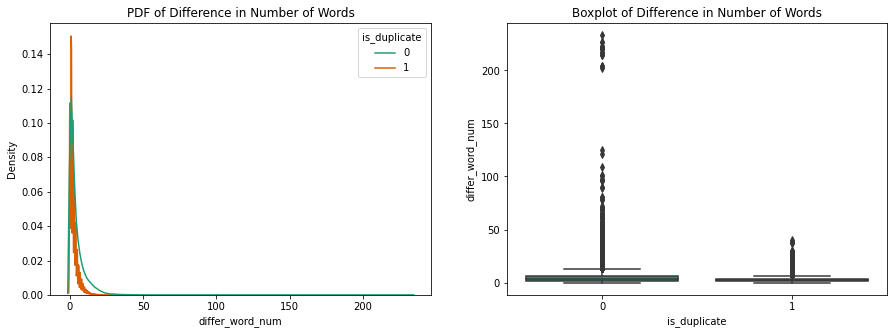

In [6]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Difference in Number of Words')
sns.kdeplot(traindata['differ_word_num'], hue=data.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Difference in Number of Words')
sns.boxplot(x=data.is_duplicate, y=traindata['differ_word_num'], palette="Dark2", ax=ax[1])
plt.show()

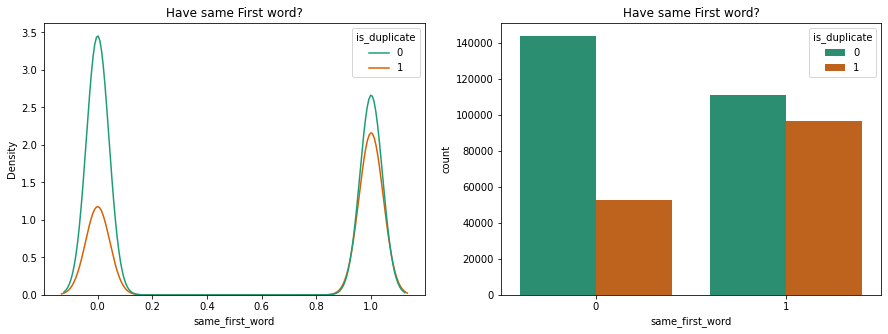

In [11]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('Have same First word?')
sns.kdeplot(traindata['same_first_word'], hue=data.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Have same First word?')
sns.countplot(x=traindata['same_first_word'], hue=data.is_duplicate, palette="Dark2", ax=ax[1])
plt.show()

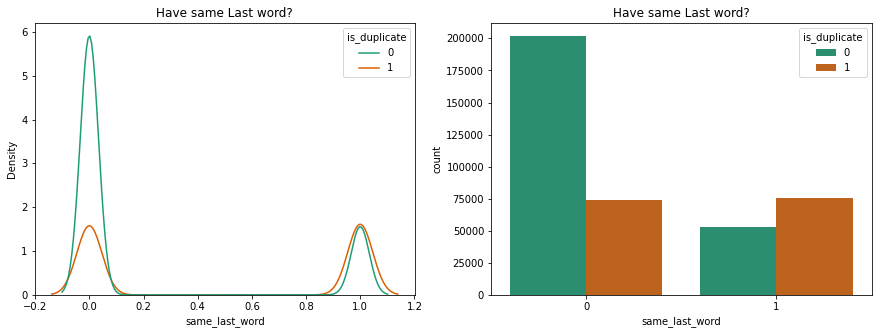

In [12]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('Have same Last word?')
sns.kdeplot(traindata['same_last_word'], hue=data.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Have same Last word?')
sns.countplot(x=traindata['same_last_word'], hue=data.is_duplicate, palette="Dark2", ax=ax[1])
plt.show()

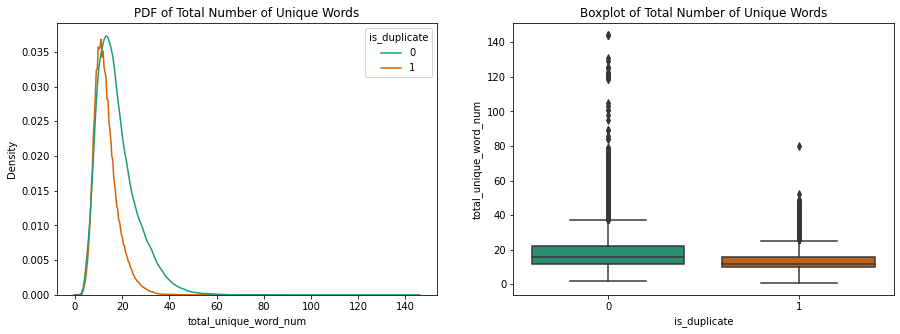

In [7]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Total Number of Unique Words')
sns.kdeplot(traindata['total_unique_word_num'], hue=data.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Total Number of Unique Words')
sns.boxplot(x=data.is_duplicate, y=traindata['total_unique_word_num'], palette="Dark2", ax=ax[1])
plt.show()

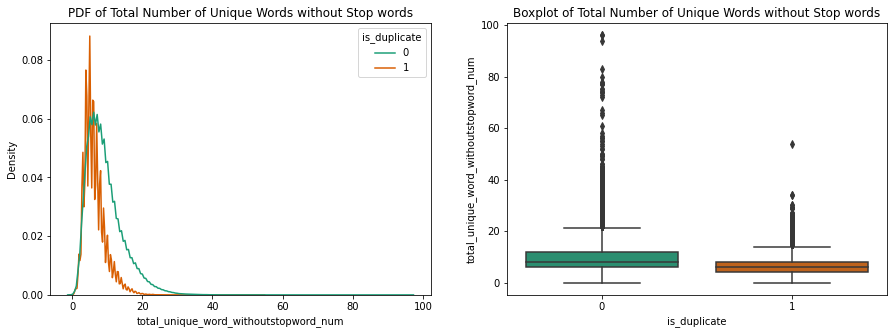

In [8]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Total Number of Unique Words without Stop words')
sns.kdeplot(traindata['total_unique_word_withoutstopword_num'], hue=data.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Total Number of Unique Words without Stop words')
sns.boxplot(x=data.is_duplicate, y=traindata['total_unique_word_withoutstopword_num'], palette="Dark2", ax=ax[1])
plt.show()

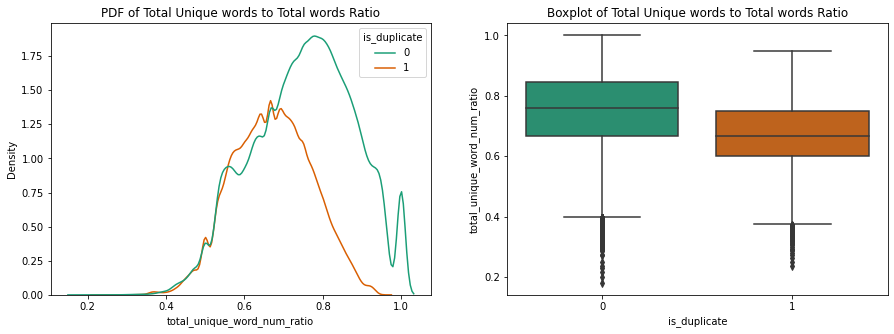

In [9]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Total Unique words to Total words Ratio')
sns.kdeplot(traindata['total_unique_word_num_ratio'], hue=data.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Total Unique words to Total words Ratio')
sns.boxplot(x=data.is_duplicate, y=traindata['total_unique_word_num_ratio'], palette="Dark2", ax=ax[1])
plt.show()

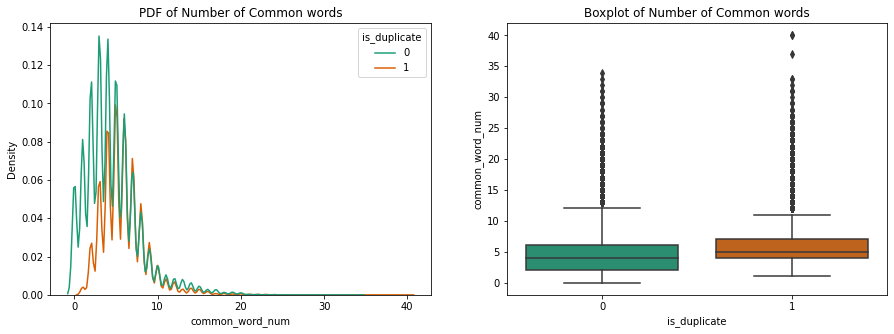

In [10]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Number of Common words')
sns.kdeplot(traindata['common_word_num'], hue=data.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Number of Common words')
sns.boxplot(x=data.is_duplicate, y=traindata['common_word_num'], palette="Dark2", ax=ax[1])
plt.show()

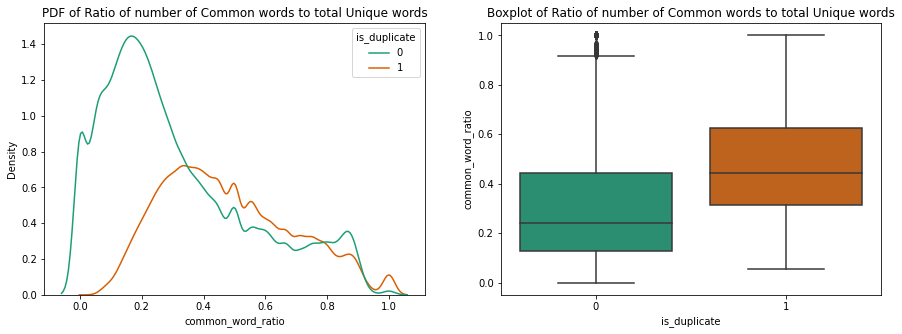

In [11]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Ratio of number of Common words to total Unique words')
sns.kdeplot(traindata['common_word_ratio'], hue=data.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Ratio of number of Common words to total Unique words')
sns.boxplot(x=data.is_duplicate, y=traindata['common_word_ratio'], palette="Dark2", ax=ax[1])
plt.show()

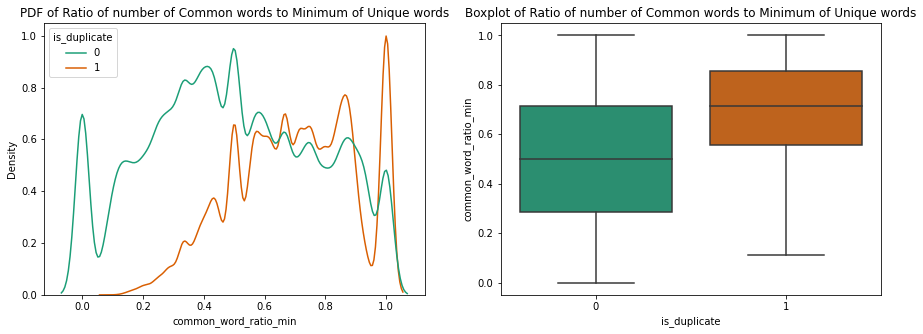

In [12]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Ratio of number of Common words to Minimum of Unique words')
sns.kdeplot(traindata['common_word_ratio_min'], hue=data.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Ratio of number of Common words to Minimum of Unique words')
sns.boxplot(x=data.is_duplicate, y=traindata['common_word_ratio_min'], palette="Dark2", ax=ax[1])
plt.show()

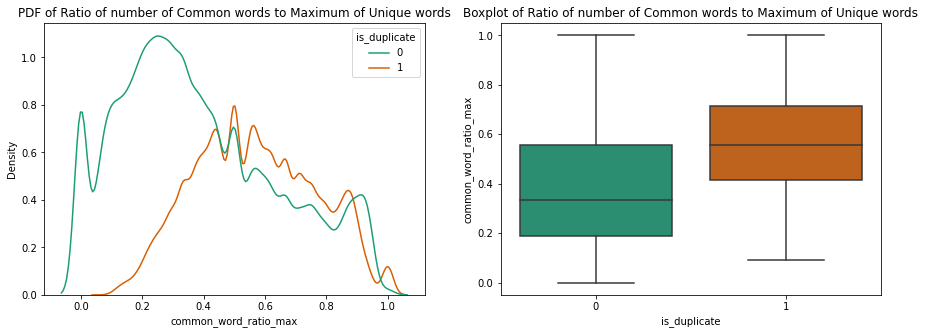

In [13]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Ratio of number of Common words to Maximum of Unique words')
sns.kdeplot(traindata['common_word_ratio_max'], hue=data.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Ratio of number of Common words to Maximum of Unique words')
sns.boxplot(x=data.is_duplicate, y=traindata['common_word_ratio_max'], palette="Dark2", ax=ax[1])
plt.show()

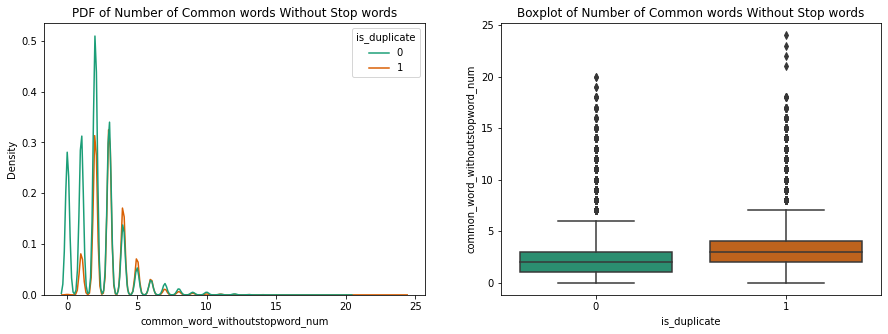

In [14]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Number of Common words Without Stop words')
sns.kdeplot(traindata['common_word_withoutstopword_num'], hue=data.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Number of Common words Without Stop words')
sns.boxplot(x=data.is_duplicate, y=traindata['common_word_withoutstopword_num'], palette="Dark2", ax=ax[1])
plt.show()

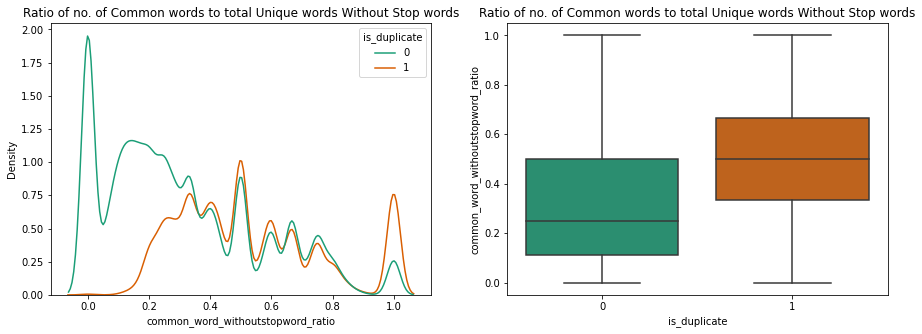

In [25]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('Ratio of no. of Common words to total Unique words Without Stop words')
sns.kdeplot(traindata['common_word_withoutstopword_ratio'], hue=data.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Ratio of no. of Common words to total Unique words Without Stop words')
sns.boxplot(x=data.is_duplicate, y=traindata['common_word_withoutstopword_ratio'], palette="Dark2", ax=ax[1])
plt.show()

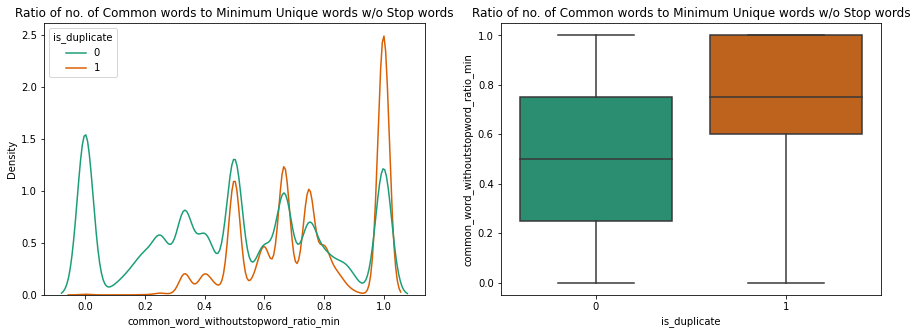

In [27]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('Ratio of no. of Common words to Minimum Unique words w/o Stop words')
sns.kdeplot(traindata['common_word_withoutstopword_ratio_min'], hue=data.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Ratio of no. of Common words to Minimum Unique words w/o Stop words')
sns.boxplot(x=data.is_duplicate, y=traindata['common_word_withoutstopword_ratio_min'], palette="Dark2", ax=ax[1])
plt.show()

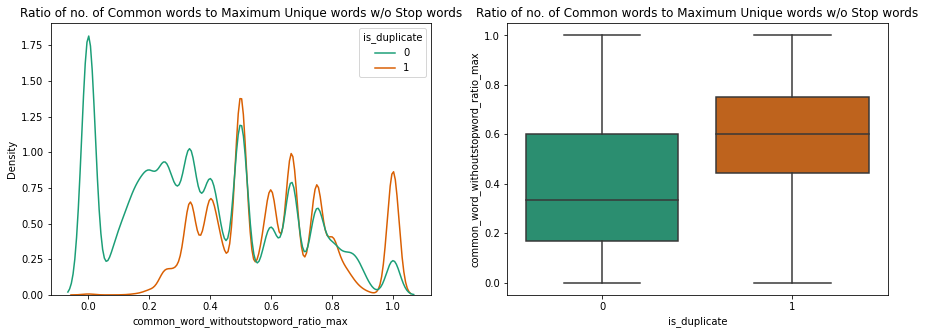

In [28]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('Ratio of no. of Common words to Maximum Unique words w/o Stop words')
sns.kdeplot(traindata['common_word_withoutstopword_ratio_max'], hue=data.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Ratio of no. of Common words to Maximum Unique words w/o Stop words')
sns.boxplot(x=data.is_duplicate, y=traindata['common_word_withoutstopword_ratio_max'], palette="Dark2", ax=ax[1])
plt.show()

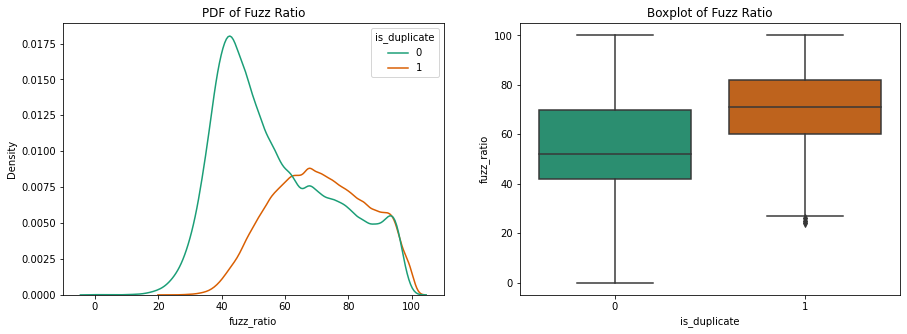

In [15]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Fuzz Ratio')
sns.kdeplot(traindata['fuzz_ratio'], hue=data.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Fuzz Ratio')
sns.boxplot(x=data.is_duplicate, y=traindata['fuzz_ratio'], palette="Dark2", ax=ax[1])
plt.show()

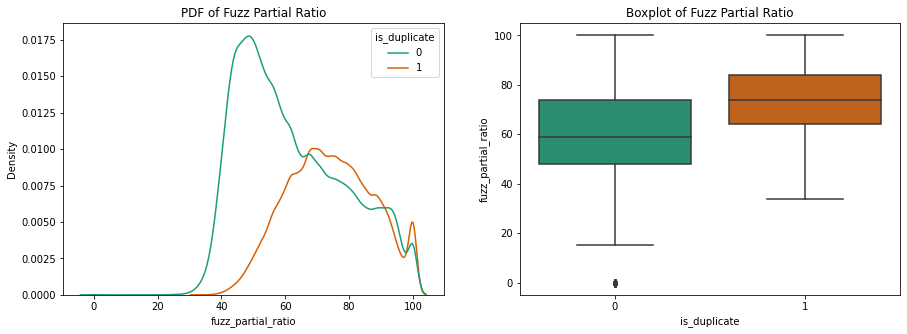

In [18]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Fuzz Partial Ratio')
sns.kdeplot(traindata['fuzz_partial_ratio'], hue=data.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Fuzz Partial Ratio')
sns.boxplot(x=data.is_duplicate, y=traindata['fuzz_partial_ratio'], palette="Dark2", ax=ax[1])
plt.show()

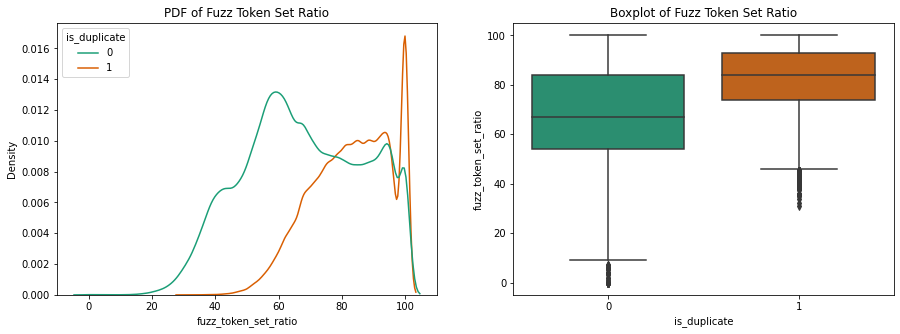

In [16]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Fuzz Token Set Ratio')
sns.kdeplot(traindata['fuzz_token_set_ratio'], hue=data.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Fuzz Token Set Ratio')
sns.boxplot(x=data.is_duplicate, y=traindata['fuzz_token_set_ratio'], palette="Dark2", ax=ax[1])
plt.show()

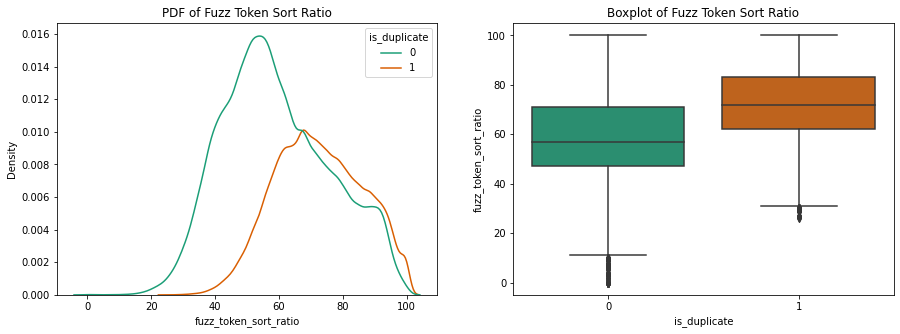

In [17]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Fuzz Token Sort Ratio')
sns.kdeplot(traindata['fuzz_token_sort_ratio'], hue=data.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Fuzz Token Sort Ratio')
sns.boxplot(x=data.is_duplicate, y=traindata['fuzz_token_sort_ratio'], palette="Dark2", ax=ax[1])
plt.show()

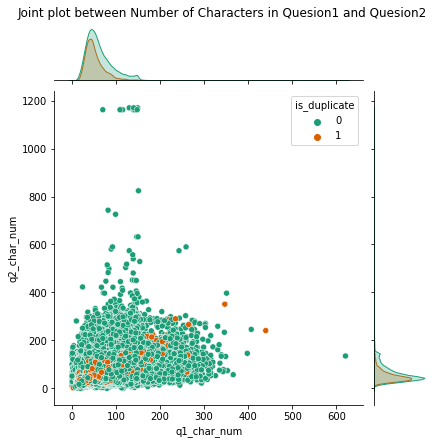

In [34]:
g = sns.jointplot(x = 'q1_char_num', y = 'q2_char_num', kind = "scatter", hue=data.is_duplicate, data = traindata, palette="Dark2")
g.fig.suptitle("Joint plot between Number of Characters in Quesion1 and Quesion2", y=1.02)
plt.show()

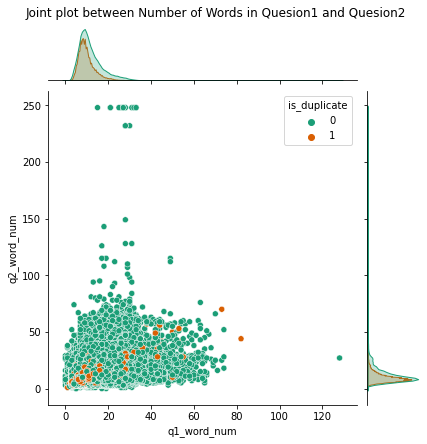

In [35]:
g = sns.jointplot(x = 'q1_word_num', y = 'q2_word_num', kind = "scatter", hue=data.is_duplicate, data = traindata, palette="Dark2")
g.fig.suptitle("Joint plot between Number of Words in Quesion1 and Quesion2", y=1.02)
plt.show()

* If First word or Last word is the same then there is a high chance that the question pairs are duplicates.
* The number of total unique words (q1 and q2 both combined) with and without stopwords is less if question pairs are duplicate.
* For duplicate question pairs, the total unique words to total words ratio is generally smaller.
* Duplicate question pairs tend to have more common words between both the questions. Hence extracted features related to common words are also showing differences in distributions.
* The fuzz ratios tend to be generally higher for duplicate question pairs.

# Sentence Embedding with SentenceBERT

I tried InferSent sentence embeddings. But it returns 4096 dimension representation. And after applying it the train data became huge. So I discarded it. And I chose SentenceBERT for this problem.

SentenceBERT is a BERT based sentence embedding technique. We will use pre-trained SentenceBERT model paraphrase-mpnet-base-v2, which is recommended for best quality. The SentenceBERT produces an output of 768 dimensions. https://www.sbert.net/

In [14]:
modelST = SentenceTransformer('paraphrase-mpnet-base-v2')

In [28]:
# It took a lot of time, caused gpu overheat.
# So I decided to do it in batch and save them in file.
def getBertEmbeddings(data, filename):
    batch = 20000
    with open(filename, 'wb') as f:
        while(len(data)):
            tempdata = data[:batch]
            data = data[batch:]
            tempembed = modelST.encode(tempdata.values, device='cuda')
            np.save(f, tempembed, allow_pickle=True)
#             time.sleep(60) # for gpu heating issue
            

In [ ]:
# Get SentenceBERT embedding of train data
getBertEmbeddings(traindata.question1_final, 'temp_train_question1_sentenceBERT.npy')
getBertEmbeddings(traindata.question2_final, 'temp_train_question2_sentenceBERT.npy')

In [ ]:
# Get SentenceBERT embedding of test data
getBertEmbeddings(testdata.question1_final, 'temp_test_question1_sentenceBERT.npy')
getBertEmbeddings(testdata.question2_final, 'temp_test_question2_sentenceBERT.npy')

In [31]:
# Get cosine similarity and euclidean distance between two vectors
def cosine_euclidean(u, v):
    return np.array([np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v)), np.linalg.norm(u - v)])

In [93]:
# open .npy files and loop through the sentence embeddings
with open('temp_train_question1_sentenceBERT.npy', 'rb') as q1_vec, open('temp_train_question2_sentenceBERT.npy', 'rb') as q2_vec:
    distances = []
    while True:
        try:
            q1_20k = np.load(q1_vec, allow_pickle=True)
            q2_20k = np.load(q2_vec, allow_pickle=True)
            for q1,q2 in zip(q1_20k, q2_20k):
                dists = cosine_euclidean(q1, q2)
                distances.append(dists)
        except IOError as e:
            distances = np.array(distances)
            break

In [94]:
distances = pd.DataFrame(distances, columns=['cosine_simlarity_bert', 'euclidean_distance_bert'])

In [95]:
traindata = pd.concat([traindata, pd.DataFrame(distances)], axis=1)

In [32]:
# open .npy files and loop through the sentence embeddings
with open('temp_test_question1_sentenceBERT.npy', 'rb') as q1_vec, open('temp_test_question2_sentenceBERT.npy', 'rb') as q2_vec:
    distances = []
    while True:
        try:
            q1_20k = np.load(q1_vec, allow_pickle=True)
            q2_20k = np.load(q2_vec, allow_pickle=True)
            for q1,q2 in zip(q1_20k, q2_20k):
                dists = cosine_euclidean(q1, q2)
                distances.append(dists)
        except IOError as e:
            distances = np.array(distances)
            break
distances = pd.DataFrame(distances, columns=['cosine_simlarity_bert', 'euclidean_distance_bert'])
testdata = pd.concat([testdata, pd.DataFrame(distances)], axis=1)

We have created two more features **cosine_simlarity_bert** and **euclidean_distance_bert** which measures similarity and distance between both pairs of questions.

The total number of features till now is **25**.

### EDA on new features related to SentenceBERT

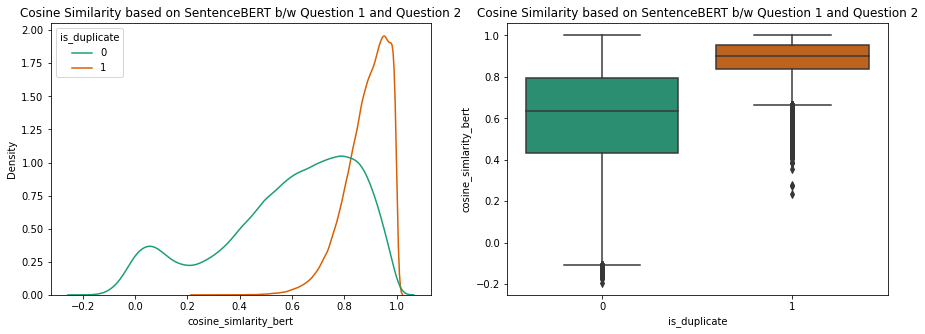

In [19]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('Cosine Similarity based on SentenceBERT b/w Question 1 and Question 2')
sns.kdeplot(traindata['cosine_simlarity_bert'], hue=data.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Cosine Similarity based on SentenceBERT b/w Question 1 and Question 2')
sns.boxplot(x=data.is_duplicate, y=traindata['cosine_simlarity_bert'], palette="Dark2", ax=ax[1])
plt.show()

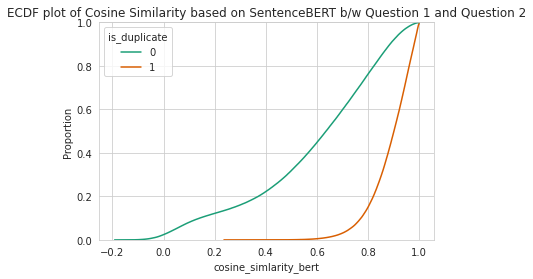

In [23]:
plt.title('ECDF plot of Cosine Similarity based on SentenceBERT b/w Question 1 and Question 2')
sns.axes_style("whitegrid")
sns.ecdfplot(x=traindata['cosine_simlarity_bert'], hue=data.is_duplicate, palette="Dark2")
plt.show()

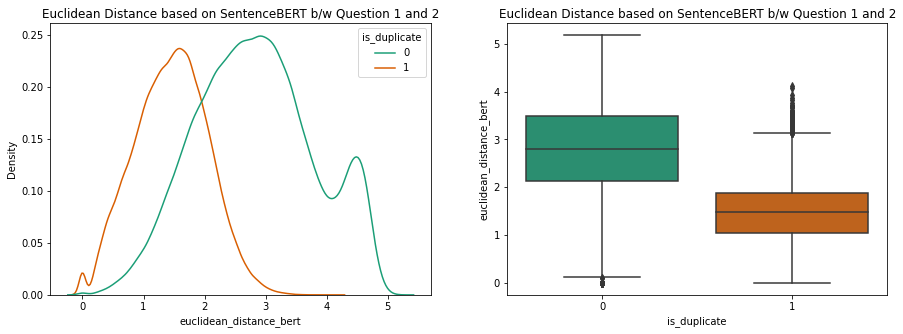

In [20]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('Euclidean Distance based on SentenceBERT b/w Question 1 and 2')
sns.kdeplot(traindata['euclidean_distance_bert'], hue=data.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Euclidean Distance based on SentenceBERT b/w Question 1 and 2')
sns.boxplot(x=data.is_duplicate, y=traindata['euclidean_distance_bert'], palette="Dark2", ax=ax[1])
plt.show()

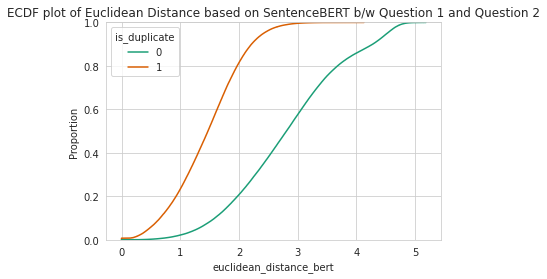

In [21]:
plt.title('ECDF plot of Euclidean Distance based on SentenceBERT b/w Question 1 and Question 2')
sns.axes_style("whitegrid")
sns.ecdfplot(x=traindata['euclidean_distance_bert'], hue=data.is_duplicate, palette="Dark2")
plt.show()

These features seems to be the most successful ones. It seems we can separate most of the classes just by using one of these features.
* Cosine Similarity is larger for duplicate pairs.
* 80% of non-duplicate question pairs and only 20% of duplicate question pairs have cosine similarity of <= .815
* Euclidean Distance is smaller for duplicate pairs.
* 20% of non-duplicate question pairs and approx 80% of duplicate question pairs have euclidean distance of <= 2.

It is showing the Pareto Principle (80-20 rule).

# Data Pre-processing

In [80]:
traindata.drop(columns=['question1_final', 'question2_final'], inplace=True)

In [81]:
traindata = traindata.to_numpy()

In [82]:
scaler = MinMaxScaler()

In [83]:
scaler.fit(traindata)

MinMaxScaler()

In [84]:
traindata = scaler.transform(traindata)

We have normalized (min-max scaling) the extracted features of train data. We have not normalized the embeddings because it is not recommended.

In [6]:
testdata.drop(columns=['question1_final', 'question2_final'], inplace=True)
testdata = testdata.to_numpy()
testdata = scaler.transform(testdata)

In [7]:
with open('temp_testdata.npy', 'wb') as f:
    batch = 20000
    while(len(testdata)):
        tempdata = testdata[:batch]
        testdata = testdata[batch:]
        np.save(f, tempdata, allow_pickle=True)

We have normalized the test data also. And save them in batch of 20k, just like we did with the embeddings.

In [88]:
def loadVectors(filename):
    with open(filename, 'rb') as f:
        q_vectors = []
        while True:
            try:
                q_vec = np.load(f, allow_pickle=True)
                q_vectors.extend(list(q_vec))
            except IOError as e:
                q_vectors = np.array(q_vectors)
                break
    return q_vectors

In [90]:
train_question1_vec = loadVectors('temp_train_question1_sentenceBERT.npy')

In [91]:
train_question2_vec = loadVectors('temp_train_question2_sentenceBERT.npy')

In [92]:
traindata = np.hstack((traindata, train_question1_vec, train_question2_vec))

In [93]:
traindata.shape

(404287, 1561)

We have **1561** features (25 + 768 + 768). <br>
* **25** are extracted features.<br>
* **768+768** for sentence embedding of question 1 and question 2.

In [96]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_train, y_train = oversample.fit_resample(traindata, data.is_duplicate.to_numpy())

In [97]:
print(np.count_nonzero(y_train == 0))
print(np.count_nonzero(y_train == 1))

255024
255024


Since the dataset was imbalanced. We did **oversample** by sampling from the minority class. <br>
Now we have **510048** data points. **255024** from each class.

Note that I have not set aside any data for testing locally. Because our main goal is to get a good score on Kaggle.

# Training Models

## Support Vector Classifier

### Training

In [2]:
splits = ShuffleSplit(n_splits=1, test_size=.3, random_state=42)

In [3]:
svc_param_grid = {'C':[1e-2, 1e-1, 1e0, 1e1, 1e2]}

In [7]:
svc_clf = LinearSVC(penalty='l2', loss='squared_hinge', dual=False, max_iter=3000)

In [8]:
svc_clf_search = HalvingGridSearchCV(svc_clf, svc_param_grid, cv=splits, factor=2, scoring='accuracy', verbose=3)

In [9]:
svc_clf_search.fit(X_train, y_train)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 127512
max_resources_: 510048
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 5
n_resources: 127512
Fitting 1 folds for each of 5 candidates, totalling 5 fits
[CV 1/1] END ........C=0.01;, score=(train=0.859, test=0.855) total time=  37.2s
[CV 1/1] END .........C=0.1;, score=(train=0.862, test=0.854) total time= 1.4min
[CV 1/1] END .........C=1.0;, score=(train=0.863, test=0.855) total time= 2.3min
[CV 1/1] END ........C=10.0;, score=(train=0.863, test=0.855) total time= 3.5min
[CV 1/1] END .......C=100.0;, score=(train=0.863, test=0.855) total time= 4.0min
----------
iter: 1
n_candidates: 3
n_resources: 255024
Fitting 1 folds for each of 3 candidates, totalling 3 fits
[CV 1/1] END .........C=1.0;, score=(train=0.861, test=0.857) total time= 5.1min
[CV 1/1] END .......C=100.0;, score=(train=0.861, test=0.857) total time= 6.1min
[CV 1/1] END ........C=10.0;, score=(train=0.861, tes

HalvingGridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=42, test_size=0.3, train_size=None),
                    estimator=LinearSVC(dual=False, max_iter=3000), factor=2,
                    param_grid={'C': [0.01, 0.1, 1.0, 10.0, 100.0]},
                    refit=<function _refit_callable at 0x7fc44740e1f0>,
                    scoring='accuracy', verbose=3)

In [10]:
svc_clf_search.best_params_

{'C': 100.0}

In [11]:
svc_clf_search.best_score_

0.8578962846779727

The Halving Grid Search CV found C=100 to be the best param. And the best accuracy is 85.79%.

In [12]:
svc_clf_model = svc_clf_search.best_estimator_

In [13]:
svc_clf_model

LinearSVC(C=100.0, dual=False, max_iter=3000)

Now since we need to minimize log loss for the competition. We would want a good predicted probability. Calibrated Classifier can be used to get a good predicted probability.

In [16]:
svc_calibrated = CalibratedClassifierCV(base_estimator=svc_clf_model, method="sigmoid", cv=splits)

In [17]:
svc_calibrated.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=LinearSVC(C=100.0, dual=False,
                                                max_iter=3000),
                       cv=ShuffleSplit(n_splits=1, random_state=42, test_size=0.3, train_size=None))

### Testing

In [51]:
with open('testdata.npy', 'rb') as X_test_1, \
    open('test_question1_sentenceBERT.npy', 'rb') as X_test_q1, \
    open('test_question2_sentenceBERT.npy', 'rb') as X_test_q2:
    y_pred_proba_svc = []
    while True:
        try:
            test_20k = np.load(X_test_1, allow_pickle=True)
            q1_20k = np.load(X_test_q1, allow_pickle=True)
            q2_20k = np.load(X_test_q2, allow_pickle=True)
            X_test = np.hstack((test_20k, q1_20k, q2_20k))
            y_pred_proba_svc.extend(list(svc_calibrated.predict_proba(X_test)[:,1]))
        except IOError as e:
            break

In [55]:
testids = pd.read_csv('test_id.csv', na_filter=False)

In [58]:
submission_svc = pd.DataFrame({'test_id':testids.test_id.values, 'is_duplicate':y_pred_proba_svc})

In [60]:
submission_svc.to_csv('submission_svc.csv', index=False)

The public leader board score for the Kaggle submission is **0.36980**<br>
It is very good considering that the model assumes linear separability.

## Random Forest

### Training

In [5]:
splits = ShuffleSplit(n_splits=1, test_size=.3, random_state=42)

In [6]:
rf_param_grid = {
                    'n_estimators':[200, 500, 800], 
                    'min_samples_split':[5, 15],
                    'max_depth': [70, 150, None]
                }

In [7]:
rf_clf = RandomForestClassifier()

In [8]:
rf_clf_search = HalvingGridSearchCV(rf_clf, rf_param_grid, cv=splits, factor=2, scoring='accuracy', verbose=3)

In [9]:
rf_clf_search.fit(X_train, y_train)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 31878
max_resources_: 510048
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 18
n_resources: 31878
Fitting 1 folds for each of 18 candidates, totalling 18 fits
[CV 1/1] END max_depth=70, min_samples_split=5, n_estimators=200;, score=(train=1.000, test=0.839) total time= 3.4min
[CV 1/1] END max_depth=70, min_samples_split=5, n_estimators=500;, score=(train=1.000, test=0.840) total time= 8.1min
[CV 1/1] END max_depth=70, min_samples_split=5, n_estimators=800;, score=(train=1.000, test=0.841) total time=12.8min
[CV 1/1] END max_depth=70, min_samples_split=15, n_estimators=200;, score=(train=0.999, test=0.839) total time= 3.0min
[CV 1/1] END max_depth=70, min_samples_split=15, n_estimators=500;, score=(train=1.000, test=0.840) total time= 7.5min
[CV 1/1] END max_depth=70, min_samples_split=15, n_estimators=800;, score=(train=1.000, test=0.840) total time=12.1min
[CV 1/1] END max_depth

HalvingGridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=42, test_size=0.3, train_size=None),
                    estimator=RandomForestClassifier(), factor=2,
                    param_grid={'max_depth': [70, 150, None],
                                'min_samples_split': [5, 15],
                                'n_estimators': [200, 500, 800]},
                    refit=<function _refit_callable at 0x7f1597f4c310>,
                    scoring='accuracy', verbose=3)

In [12]:
rf_clf_search.best_params_

{'max_depth': 150, 'min_samples_split': 5, 'n_estimators': 800}

In [13]:
rf_clf_search.best_score_

0.9052576544783191

In [14]:
rf_clf_model = rf_clf_search.best_estimator_

In [16]:
rf_clf_model

RandomForestClassifier(max_depth=150, min_samples_split=5, n_estimators=800)

### Testing

In [3]:
with open('testdata.npy', 'rb') as X_test_1, \
    open('test_question1_sentenceBERT.npy', 'rb') as X_test_q1, \
    open('test_question2_sentenceBERT.npy', 'rb') as X_test_q2:
    y_pred_proba_rf = []
    while True:
        try:
            test_20k = np.load(X_test_1, allow_pickle=True)
            q1_20k = np.load(X_test_q1, allow_pickle=True)
            q2_20k = np.load(X_test_q2, allow_pickle=True)
            X_test = np.hstack((test_20k, q1_20k, q2_20k))
            y_pred_proba_rf.extend(list(rf_clf_model.predict_proba(X_test)[:,1]))
        except IOError as e:
            break

In [4]:
testids = pd.read_csv('test_id.csv', na_filter=False)

In [5]:
submission_rf = pd.DataFrame({'test_id':testids.test_id.values, 'is_duplicate':y_pred_proba_rf})

In [6]:
submission_rf.to_csv('submission_rf.csv', index=False)

The public leader board score for the Kaggle submission is **0.32372**, which slightly better than SVC.<br>
I was expecting a little less logloss but remember we have not done calibration (due to time constraints).

## XGBoost

Due to time and system configuration constrained, I decided to use 200000 data points to estimate a few of the params.<br>
At first, I was using Optuna for hyperparameter tuning but it had some issues because of which it was not releasing memory after the trials. So the system was crash after few trials.<br>
Later on, I decided to use HyperOpt for the tuning.

### Training

In [4]:
random_2l = np.random.choice(range(len(X_train)), size=200000, replace=False)

In [6]:
X_train_2l = X_train[random_2l]
y_train_2l = y_train[random_2l]

In [8]:
def objective(space):
    warnings.filterwarnings(action='ignore', category=UserWarning)
    classifier = xgb.XGBClassifier(
                    objective = "binary:logistic",
                    eval_metric = "logloss",
                    booster = "gbtree",
                    tree_method = "hist",
                    grow_policy = "lossguide",
                    n_estimators = 300, 
                    max_depth = space['max_depth'],
                    learning_rate = space['learning_rate'],
                )
    
    X_train, X_cv, y_train, y_cv = train_test_split(X_train_2l, y_train_2l, test_size=0.25)
    
    classifier.fit(X_train, y_train)
    
    predicted_probs = classifier.predict_proba(X_cv)

    logloss = log_loss(y_cv, predicted_probs)

    print("Log loss = " + str(logloss))

    return{'loss':logloss, 'status': STATUS_OK }


In [9]:
space = {
    'max_depth' : hp.choice('max_depth', range(4, 10, 1)),
    "learning_rate": hp.quniform("learning_rate", 0.01, 0.5, 0.01)
}

In [10]:
trials = Trials()
best_param = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=5,
            trials=trials)

Log loss = 0.28772759911202744                                                  
Log loss = 0.2685568001015416                                                   
Log loss = 0.29722632654272924                                                  
Log loss = 0.2961086556572912                                                   
Log loss = 0.3051178325778841                                                   
100%|███████| 5/5 [1:29:34<00:00, 1074.82s/trial, best loss: 0.2685568001015416]


In [12]:
print("Best Param : ", best_param)

Best Param :  {'learning_rate': 0.14, 'max_depth': 4}


Train the model on whole data with the tuned parameters.

In [4]:
params = dict(
            objective = "binary:logistic",
            eval_metric = "logloss",
            booster = "gbtree",
            tree_method = "hist",
            grow_policy = "lossguide",
            max_depth = 4,
            eta = 0.14
        )

In [5]:
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2)

In [6]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_cv, label=y_cv)

In [7]:
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [8]:
xgb_model = xgb.train(params, dtrain, 600, watchlist, early_stopping_rounds=20, verbose_eval=10)

[0]	train-logloss:0.62787	valid-logloss:0.62785
[10]	train-logloss:0.40672	valid-logloss:0.40608
[20]	train-logloss:0.36767	valid-logloss:0.36733
[30]	train-logloss:0.35168	valid-logloss:0.35172
[40]	train-logloss:0.34022	valid-logloss:0.34069
[50]	train-logloss:0.33256	valid-logloss:0.33378
[60]	train-logloss:0.32649	valid-logloss:0.32834
[70]	train-logloss:0.32144	valid-logloss:0.32384
[80]	train-logloss:0.31738	valid-logloss:0.32032
[90]	train-logloss:0.31371	valid-logloss:0.31732
[100]	train-logloss:0.31063	valid-logloss:0.31490
[110]	train-logloss:0.30769	valid-logloss:0.31253
[120]	train-logloss:0.30484	valid-logloss:0.31029
[130]	train-logloss:0.30245	valid-logloss:0.30856
[140]	train-logloss:0.30007	valid-logloss:0.30680
[150]	train-logloss:0.29805	valid-logloss:0.30541
[160]	train-logloss:0.29583	valid-logloss:0.30381
[170]	train-logloss:0.29354	valid-logloss:0.30226
[180]	train-logloss:0.29137	valid-logloss:0.30075
[190]	train-logloss:0.28944	valid-logloss:0.29945
[200]	train

### Testing

In [16]:
with open('testdata.npy', 'rb') as X_test_1, \
    open('test_question1_sentenceBERT.npy', 'rb') as X_test_q1, \
    open('test_question2_sentenceBERT.npy', 'rb') as X_test_q2:
    y_pred_proba_xgb = []
    while True:
        try:
            test_20k = np.load(X_test_1, allow_pickle=True)
            q1_20k = np.load(X_test_q1, allow_pickle=True)
            q2_20k = np.load(X_test_q2, allow_pickle=True)
            X_test = xgb.DMatrix(np.hstack((test_20k, q1_20k, q2_20k)))
            y_pred_proba_xgb.extend(list(xgb_model.predict(X_test)))
        except IOError as e:
            break

In [20]:
testids = pd.read_csv('test_id.csv', na_filter=False)

In [21]:
submission_xgb = pd.DataFrame({'test_id':testids.test_id.values, 'is_duplicate':y_pred_proba_xgb})

In [22]:
submission_xgb.to_csv('submission_xgb.csv', index=False)

The public leader board score for the Kaggle submission is **0.32105**, which slightly better than the other models. I was expecting a better result than this. Which is possible with more fine-tuning the hyperparameters. XGBoost have tons of hyperparameters https://xgboost.readthedocs.io/en/latest/parameter.html

## Another XGBoost

I was not happy with the result of the XGBoost model so I decided to tune the parameters with gut feeling.

### Training

In [11]:
X_train_orig, idices = np.unique(X_train, axis=0, return_index=True)

In [12]:
y_train_orig = y_train[idices]

In [13]:
X_train_orig.shape

(403940, 1561)

We got rid of oversampled data by removing the duplicate rows.

In [4]:
params = dict(
            objective = "binary:logistic",
            eval_metric = "logloss",
            booster = "gbtree",
            tree_method = "hist",
            grow_policy = "lossguide",
            max_depth = 4,
            eta = 0.15,
            subsample = .8,
            colsample_bytree = .8,
            reg_lambda = 1,
            reg_alpha = 1
        )

I chose few more params based on instinct.

In [5]:
X_train, X_cv, y_train, y_cv = train_test_split(X_train_orig, y_train_orig, test_size=0.25)

In [6]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_cv, label=y_cv)

In [7]:
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [8]:
xgb_model2 = xgb.train(params, dtrain, 500, watchlist, early_stopping_rounds=20, verbose_eval=10)

[0]	train-logloss:0.62420	valid-logloss:0.62430
[10]	train-logloss:0.39826	valid-logloss:0.39854
[20]	train-logloss:0.35911	valid-logloss:0.35996
[30]	train-logloss:0.34384	valid-logloss:0.34563
[40]	train-logloss:0.33342	valid-logloss:0.33610
[50]	train-logloss:0.32587	valid-logloss:0.32959
[60]	train-logloss:0.31950	valid-logloss:0.32411
[70]	train-logloss:0.31465	valid-logloss:0.32005
[80]	train-logloss:0.31063	valid-logloss:0.31706
[90]	train-logloss:0.30688	valid-logloss:0.31417
[100]	train-logloss:0.30387	valid-logloss:0.31206
[110]	train-logloss:0.30093	valid-logloss:0.30996
[120]	train-logloss:0.29834	valid-logloss:0.30837
[130]	train-logloss:0.29572	valid-logloss:0.30658
[140]	train-logloss:0.29337	valid-logloss:0.30513
[150]	train-logloss:0.29116	valid-logloss:0.30366
[160]	train-logloss:0.28899	valid-logloss:0.30231
[170]	train-logloss:0.28686	valid-logloss:0.30088
[180]	train-logloss:0.28486	valid-logloss:0.29982
[190]	train-logloss:0.28304	valid-logloss:0.29883
[200]	train

### Testing

In [17]:
with open('testdata.npy', 'rb') as X_test_1, \
    open('test_question1_sentenceBERT.npy', 'rb') as X_test_q1, \
    open('test_question2_sentenceBERT.npy', 'rb') as X_test_q2:
    y_pred_proba_xgb = []
    while True:
        try:
            test_20k = np.load(X_test_1, allow_pickle=True)
            q1_20k = np.load(X_test_q1, allow_pickle=True)
            q2_20k = np.load(X_test_q2, allow_pickle=True)
            X_test = xgb.DMatrix(np.hstack((test_20k, q1_20k, q2_20k)))
            y_pred_proba_xgb.extend(list(xgb_model2.predict(X_test)))
        except IOError as e:
            break
testids = pd.read_csv('test_id.csv', na_filter=False)
submission_xgb2 = pd.DataFrame({'test_id':testids.test_id.values, 'is_duplicate':y_pred_proba_xgb})
submission_xgb2.to_csv('submission_xgb2.csv', index=False)

🥁 Voila! We have a winner. **This submission resulted in public LB score of 0.28170**<br>
This seems a very good result.

# Future Work

We can try Deep learning based models to get even better result.